# NY Times News Article Classifier

## Data Flow:
* Loading data in memory
    * Load data from pickle file
    * Shuffle data
    * Load data into Spark dataframe
    * Split data into training and test set
* Pipeline
    * Tokenize
    * Remove stop words
    * Apply TF-IDF
    * Convert string labels into index
    * Apply ML algorithm (Logistic Regression, Naive Bayes, Random Forest)
    * Convert prediction index back to labels
* Cross validation
    * Use Param grid builder to add hyperparameters for each of algorithm
* Evaluation
    * Get confusion matrix
    * Calculate following metrics:
        * Precision
        * F1-Score
        * Recall
        * Weighted False positive rate
* Use Query data and perform evaluation on that

In [75]:
# Imports
from pyspark.ml import Pipeline 

# Classification algorithms
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier

# Evaluations
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix

# Data pre-processers and Feature selections
from pyspark.ml.feature import HashingTF, IDF, Tokenizer 
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import OneHotEncoder, IndexToString, StringIndexer, VectorIndexer, VectorAssembler

# Model tuning
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# Spark
from pyspark import SparkContext 
from pyspark.sql.functions import col
from pyspark import SQLContext 

# Other
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pickle
import random

In [76]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """


    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Load data from Pickle

In [77]:
# Import Pickle
with open('trainingCV.pickle', 'rb') as handle: 
    b = pickle.load(handle) 

listData = b['DF']
random.shuffle(listData)
random.shuffle(listData)

### Creating spark context

In [78]:
# Create Spark Comtext
sc = SparkContext.getOrCreate() 
spark = SQLContext(sc) 

### Loading data into Spark Data frame

In [79]:
# Load Data in spark data frame 
sentenceData = spark.createDataFrame(listData)

/home/krithika/anaconda3/lib/python3.6/site-packages/pyspark/sql/session.py:340: UserWarning: inferring schema from dict is deprecated,please use pyspark.sql.Row instead
  warnings.warn("inferring schema from dict is deprecated,"


In [80]:
# Rename column label since label is used in further down pipeline
sentenceData = sentenceData.withColumnRenamed("label","category")

### Total Data Count

In [81]:
sentenceData.count()

336

### Removing duplicate articles

In [82]:
sentenceData = sentenceData.distinct()
sentenceData.count()

317

### Group by label catergory

In [83]:
# Data group by count
sentenceData.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|category|count|
+--------+-----+
|  Sports|   99|
|Business|   87|
|   Music|   69|
|Politics|   62|
+--------+-----+



### Spliting data into training and test set

In [84]:
# Train Test split
training, test = sentenceData.randomSplit([0.8, 0.2], seed=12345)

In [85]:
# Show train data
training.show()

+--------------------+--------+
|             article|category|
+--------------------+--------+
|AUGUSTA, Ga. — Al...|  Sports|
|Levi Strauss & Co...|   Music|
|Investors seemed ...|Business|
|The warning is ta...|  Sports|
|WASHINGTON —  Cal...|Politics|
|KONGENS LYNGBY, D...|  Sports|
|NEW ORLEANS —  In...|   Music|
|Our guide to the ...|   Music|
|The publisher of ...|Business|
|(Reuters) - U.S. ...|Business|
|PARIS —  France w...|Business|
|KIEV —  Ukraine's...|Business|
|NEW YORK —  With ...|  Sports|
|(Reuters) - Healt...|Politics|
|The national trai...|  Sports|
|LISBON, Portugal ...|   Music|
|Professional tenn...|  Sports|
|The number of job...|  Sports|
|We recently reach...|  Sports|
|A bipartisan grou...|  Sports|
+--------------------+--------+
only showing top 20 rows



### Initializing objects required for pipeline

In [108]:
# Configure an ML pipeline, which consists of tree stages: tokenizer, hashingTF, and lr. 

tokenizer = Tokenizer(inputCol="article",
                      outputCol="words") 

remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), 
                           outputCol="filtered")


hashingTF = HashingTF(inputCol=remover.getOutputCol(), 
                      outputCol="hashFeatures") 

idf = IDF(inputCol=hashingTF.getOutputCol(),
          outputCol="features")
label_stringIdx = StringIndexer(inputCol = "category", 
                                outputCol = "label").fit(training)


labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedLabel",
                               labels=label_stringIdx.labels)

featureIndexer = VectorIndexer(inputCol="features", 
                              outputCol="indexedFeatures",
                              maxCategories=4)

# ML Algorithms

rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features")

nb = NaiveBayes(modelType="multinomial")

lr = LogisticRegression(maxIter=10, 
                        family="multinomial") 

In [119]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [120]:

layers = [4, 5, 4, 3]

# create the trainer and set its parameters
mpc = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

In [121]:
# Fit the model

pipeline_mpc = Pipeline(stages=[tokenizer,remover, hashingTF, idf, label_stringIdx, mpc,labelConverter]) 


# # Print the coefficients and intercept for linear SVC
# print("Coefficients: " + str(lsvcModel.coefficients))
# print("Intercept: " + str(lsvcModel.intercept))

In [58]:
# Pipelines

# Logistic Regression
pipeline_LR = Pipeline(stages=[tokenizer,remover, hashingTF, label_stringIdx, lr,labelConverter]) 

# Random Forest
pipeline_RF = Pipeline(stages=[tokenizer,remover, hashingTF, label_stringIdx, rf,labelConverter]) 

# Naive Bayes
pipeline_NB = Pipeline(stages=[tokenizer,remover, hashingTF, label_stringIdx, nb,labelConverter]) 

# We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance. 

# This will allow us to jointly choose parameters for all Pipeline stages. 

# A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator. 

# We use a ParamGridBuilder to construct a grid of parameters to search over. 

# With 3 values for hashingTF.numFeatures and 2 values for lr.regParam, 

# this grid will have 3 x 2 = 6 parameter settings for CrossValidator to choose from. 


In [124]:
# Cross validation
# num_evals=200, logC=[-5, 2], logGamma=[-5, 1]


crossval_mpc = CrossValidator(estimator=pipeline_mpc, 
                          evaluator=MulticlassClassificationEvaluator(), 
                          numFolds=5) 

In [125]:
cvModel_mpc = crossval_mpc.fit(training) 


KeyError: Param(parent='CrossValidator_4780a3287c6bd7f2680d', name='estimatorParamMaps', doc='estimator param maps')

In [102]:
# Logistic Regression
paramGrid_LR = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1]) \
    .build()

crossval_LR = CrossValidator(estimator=pipeline_LR, 
                          estimatorParamMaps=paramGrid_LR, 
                          evaluator=MulticlassClassificationEvaluator(), 
                          numFolds=5)  # use 3+ folds in practice 

In [60]:
# Naive Bayes

paramGrid_NB = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) \
    .build()
    
crossval_NB = CrossValidator(estimator=pipeline_NB, 
                          estimatorParamMaps=paramGrid_NB, 
                          evaluator=MulticlassClassificationEvaluator(), 
                          numFolds=5)  # use 3+ folds in practice 

In [61]:
# Random Forest

paramGrid_RF = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(rf.numTrees, [10, 100, 500]) \
    .build()
    
crossval_RF = CrossValidator(estimator=pipeline_RF, 
                          estimatorParamMaps=paramGrid_RF, 
                          evaluator=MulticlassClassificationEvaluator(), 
                          numFolds=5)  # use 3+ folds in practice 

In [ ]:
#Fit data for Logistic Regression
cvModel_LR = crossval_LR.fit(training) 

#Fit data for Naive Bayes
cvModel_NB = crossval_NB.fit(training) 

#Fit data for Logistic Regression
cvModel_RF = crossval_RF.fit(training)

Precision: #True positives/ (#True positives+ #False positives)

Recall: #True positives/(#True positives + #False negatives)

F-score: mean of precision and accuracy = 2*precision*recall/(precision+recall)

In [ ]:
# Import new Search Data
with open('searchData.pickle', 'rb') as handle: 
    u = pickle.load(handle) 

listDataNew = u['DF']
random.shuffle(listDataNew)
random.shuffle(listDataNew)

In [ ]:
# Load Data in spark data frame 
searchData = spark.createDataFrame(listDataNew)

# Rename column label since label is used in further down pipeline
searchData = searchData.withColumnRenamed("label","category")
searchData.count()

In [100]:
def getStats(model,inpData):
    # Prediction

    #Logistic Regression
    prediction = model.transform(inpData) 
    predictionAndLabel = prediction.select("prediction", "label").rdd
    npLbl = np.array(prediction.select( "label").collect(),dtype=int)
    npPred = np.array(prediction.select("prediction").collect(),dtype=int)
    metrics = MulticlassMetrics(predictionAndLabel)
    plot_confusion_matrix(cm           = confusion_matrix(npLbl,npPred), 
                          normalize    = False,
                          target_names = label_stringIdx.labels,
                          title        = "Confusion Matrix")
    print("Precision :",metrics.precision()) # precision
    print("F-Score :",metrics.fMeasure()) #f1 score
    print("Recall :",metrics.recall()) # recall
    print("Weighted False Positive Rate :",metrics.weightedFalsePositiveRate) # false positive rate

## Linear Regression 

In [ ]:
getStats(cvModel_LR,test)
getStats(cvModel_LR,searchData)

## Naive Bayes

In [ ]:
getStats(cvModel_NB,test)
getStats(cvModel_NB,searchData)

## Random Forest

In [ ]:
getStats(cvModel_RF,test)
getStats(cvModel_RF,searchData)

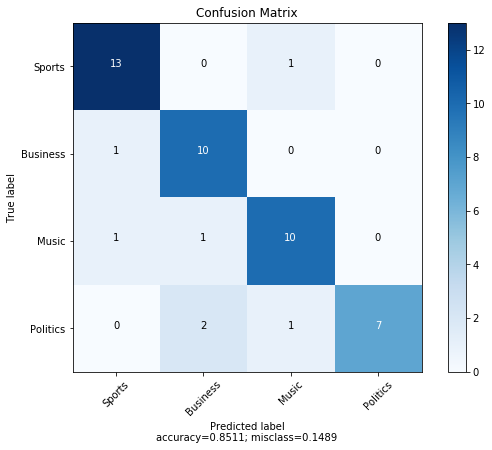

Precision : 0.851063829787234
F-Score : 0.851063829787234
Recall : 0.851063829787234
Weighted False Positive Rate : 0.05214608086948513


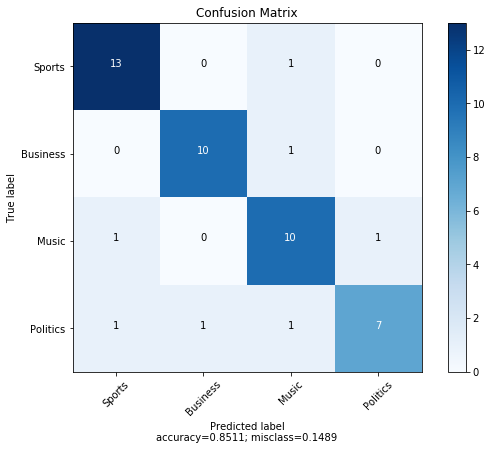

Precision : 0.851063829787234
F-Score : 0.851063829787234
Recall : 0.851063829787234
Weighted False Positive Rate : 0.05218898091238516


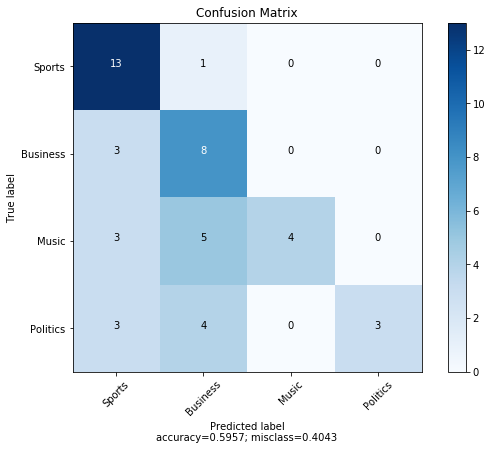

Precision : 0.5957446808510638
F-Score : 0.5957446808510638
Recall : 0.5957446808510638
Weighted False Positive Rate : 0.14624973135611435


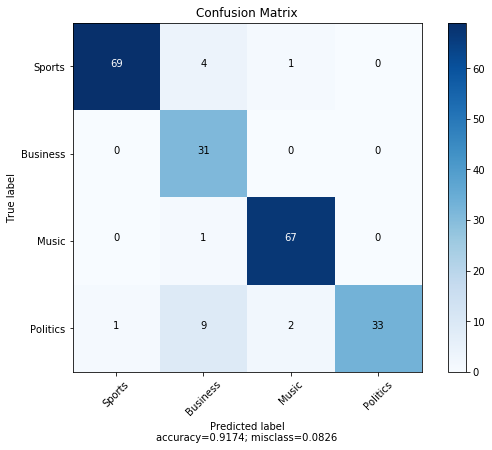

Precision : 0.9174311926605505
F-Score : 0.9174311926605505
Recall : 0.9174311926605505
Weighted False Positive Rate : 0.01924194726542271


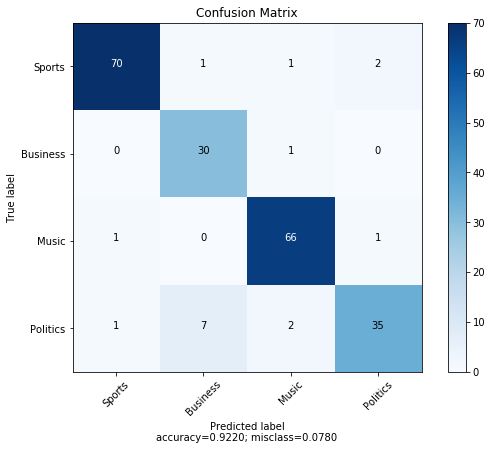

Precision : 0.9220183486238532
F-Score : 0.9220183486238532
Recall : 0.9220183486238532
Weighted False Positive Rate : 0.022695693304938116


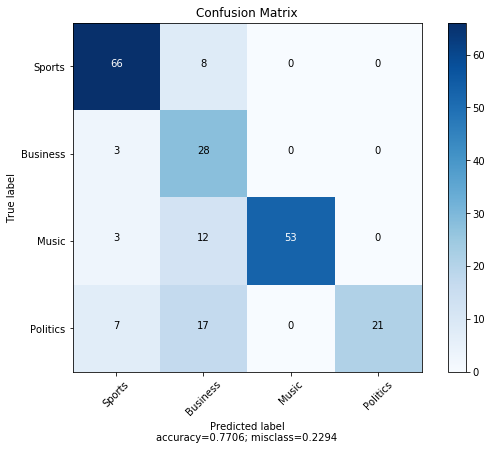

Precision : 0.7706422018348624
F-Score : 0.7706422018348624
Recall : 0.7706422018348624
Weighted False Positive Rate : 0.05878094217948508


In [69]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

sentenceData = spark.createDataFrame([
    (0.0, "Hi I heard about Spark"),
    (0.0, "I wish Java could use case classes"),
    (1.0, "Logistic regression models are neat")
], ["label", "sentence"])

tokenizer = Tokenizer(inputCol="sentence", outputCol="words")
wordsData = tokenizer.transform(sentenceData)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=5)


AttributeError: 'HashingTF' object has no attribute 'fit'

In [70]:
hashingTF

In [74]:
featurizedData.collect()

[Row(label=0.0, sentence='Hi I heard about Spark', words=['hi', 'i', 'heard', 'about', 'spark'], rawFeatures=SparseVector(5, {0: 2.0, 2: 2.0, 4: 1.0})),
 Row(label=0.0, sentence='I wish Java could use case classes', words=['i', 'wish', 'java', 'could', 'use', 'case', 'classes'], rawFeatures=SparseVector(5, {0: 1.0, 2: 2.0, 3: 1.0, 4: 3.0})),
 Row(label=1.0, sentence='Logistic regression models are neat', words=['logistic', 'regression', 'models', 'are', 'neat'], rawFeatures=SparseVector(5, {0: 1.0, 1: 1.0, 3: 2.0, 4: 1.0}))]

In [53]:
# alternatively, CountVectorizer can also be used to get term frequency vectors

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.select("label", "features").show()
for features_label in rescaledData.select("features", "label").take(3):
    print(features_label)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(5,[0,2,4],[0.0,0...|
|  0.0|(5,[0,2,3,4],[0.0...|
|  1.0|(5,[0,1,3,4],[0.0...|
+-----+--------------------+

Row(features=SparseVector(5, {0: 0.0, 2: 0.5754, 4: 0.0}), label=0.0)
Row(features=SparseVector(5, {0: 0.0, 2: 0.5754, 3: 0.2877, 4: 0.0}), label=0.0)
Row(features=SparseVector(5, {0: 0.0, 1: 0.6931, 3: 0.5754, 4: 0.0}), label=1.0)


In [37]:
rescaledData.schema["features"]



StructField(features,VectorUDT,true)

In [54]:
ddf = rescaledData.select("label", "features").rdd

In [68]:
from pyspark.ml.feature import CountVectorizer

df = sc.parallelize([
    (1, ["foo", "bar"]), (2, ["foo", "foobar", "baz"])
]).toDF(["id", "tokens"])

vectorizer = CountVectorizer(inputCol="tokens", outputCol="features").fit(df)
vectorizer.transform(df).show()
vectorizer.vocabulary
## ('foo', 'baz', 'bar', 'foobar')

+---+------------------+--------------------+
| id|            tokens|            features|
+---+------------------+--------------------+
|  1|        [foo, bar]| (4,[0,3],[1.0,1.0])|
|  2|[foo, foobar, baz]|(4,[0,1,2],[1.0,1...|
+---+------------------+--------------------+



['foo', 'foobar', 'baz', 'bar']

In [52]:
np.array(ddf.collect())

ValueError: setting an array element with a sequence.

In [33]:
from pyspark.sql.types import *
vector_udf = rescaledData(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))

TypeError: 'DataFrame' object is not callable

In [32]:
df.show() ## my sample dataframe
+-------------------+
|           features|
+-------------------+
|(4,[1,3],[3.0,4.0])|
|(4,[1,3],[3.0,4.0])|
|(4,[1,3],[3.0,4.0])|
+-------------------+

colvalues = df.select(vector_udf('features').alias('features')).collect()

list(map(lambda x:x.features,colvalues))
[[0.0, 3.0, 0.0, 4.0], [0.0, 3.0, 0.0, 4.0], [0.0, 3.0, 0.0, 4.0]]

AnalysisException: "cannot resolve '`features`' given input columns: [label, sentence];;\n'Project ['features]\n+- AnalysisBarrier\n      +- LogicalRDD [label#179, sentence#180], false\n"

In [26]:
Convert result to distributed matrix:

from pyspark.mllib.linalg.distributed import RowMatrix

matrix = RowMatrix(vectors)

If you want DenseVectors (memory requirements!):

vectors = df.select("features").rdd.map(lambda row: row.features.toArray())

MapPartitionsRDD[135] at javaToPython at NativeMethodAccessorImpl.java:0

In [ ]:
from pyspark.sql.types import *

In [31]:
vector_udf = sentenceData(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))


TypeError: 'DataFrame' object is not callable

In [28]:
vector_udf = udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))

df.show() ## my sample dataframe
+-------------------+
|           features|
+-------------------+
|(4,[1,3],[3.0,4.0])|
|(4,[1,3],[3.0,4.0])|
|(4,[1,3],[3.0,4.0])|
+-------------------+

colvalues = df.select(vector_udf('features').alias('features')).collect()

list(map(lambda x:x.features,colvalues))
[[0.0, 3.0, 0.0, 4.0], [0.0, 3.0, 0.0, 4.0], [0.0, 3.0, 0.0, 4.0]]

AttributeError: 'SQLContext' object has no attribute 'textFile'